# Phenopacket store statistics

This notebook performs quality assessment and calculate descriptive statistics about a phenopacket-store release. 

The input file is the zip file that is or will be added to each release.

In [1]:
from ppktstore.stats import PPKtStoreStats
import pandas as pd
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
stats = PPKtStoreStats(input_zipfile="all_phenopackets.zip")

In [3]:
df = stats.get_df()
df.head(2)

,disease,disease_id,patient_id,gene,allele_1,allele_2,PMID
0,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual KCHYD24-1,ESAM,NM_138961.3:c.605T>G,,PMID:36996813
1,"Neurodevelopmental disorder with intracranial hemorrhage, seizures, and spasticity",OMIM:620371,Individual 1,ESAM,NM_138961.3:c.115del,,PMID:36996813


In [4]:
df.columns

Index(['disease', 'disease_id', 'patient_id', 'gene', 'allele_1', 'allele_2',
       'PMID'],
      dtype='object')

In [5]:
stats_d = stats.get_descriptive_stats()
items = list()
for k,v in stats_d.items():
    items.append({"item": k, "value": v})
df = pd.DataFrame(items)
df.head(30)

,item,value
0,phenopackets,4343
1,diseases,395
2,genes,357
3,alleles,2289
4,PMIDs,661
5,individuals per disease (max),464
6,individuals per disease (min),1
7,individuals per disease (mean),10.994937
8,individuals per disease (median),1.0
9,individuals per disease (n>=10),92


In [6]:
#df.groupby("disease_id").count()
df["unique_id"] = df["patient_id"] + df["PMID"]
df.head()

KeyError: 'patient_id'

In [ ]:
grouped_by_disease = df.groupby("disease_id").count()
grouped_by_disease.head()


,disease,patient_id,gene,allele_1,allele_2,PMID,unique_id,disease_count
disease_id,,,,,,,,
OMIM:101200,2,2,2,2,2,2,2,0
OMIM:102370,14,14,14,14,14,14,14,0
OMIM:102500,1,1,1,1,1,1,1,0
OMIM:102700,1,1,1,1,1,1,1,0
OMIM:103500,1,1,1,1,1,1,1,0


In [ ]:
counts_per_disease = stats.get_counts_per_disease()
counts_per_disease.head(2)

disease_id
OMIM:612164    464
OMIM:613721    343
Name: count, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_with_max(
        disease_counts: pd.Series,
        max_val: int,
        ax=None,
        ):
    assert isinstance(max_val, int) and max_val > 0, '`max_val` must be a positive `int`'

    if ax is None:
        _, ax = plt.subplots(figsize=(7, 4), dpi=300)

    bins = list(range(max_val + 1)) + [disease_counts.max() + 1]
    labels = list(map(str, bins[:-2])) + [f'  ≥{max_val}']
    cats = pd.cut(
        x=disease_counts,
        bins=bins,
        labels=labels,
        right=False,
    )
    cat_count = cats.value_counts().sort_index()
    ax.bar(x=cat_count.index, height=cat_count.values)
    ax.set(
        xlabel='Number of cases',
        ylabel='Disease count',
    )
    ax.grid(axis='y')


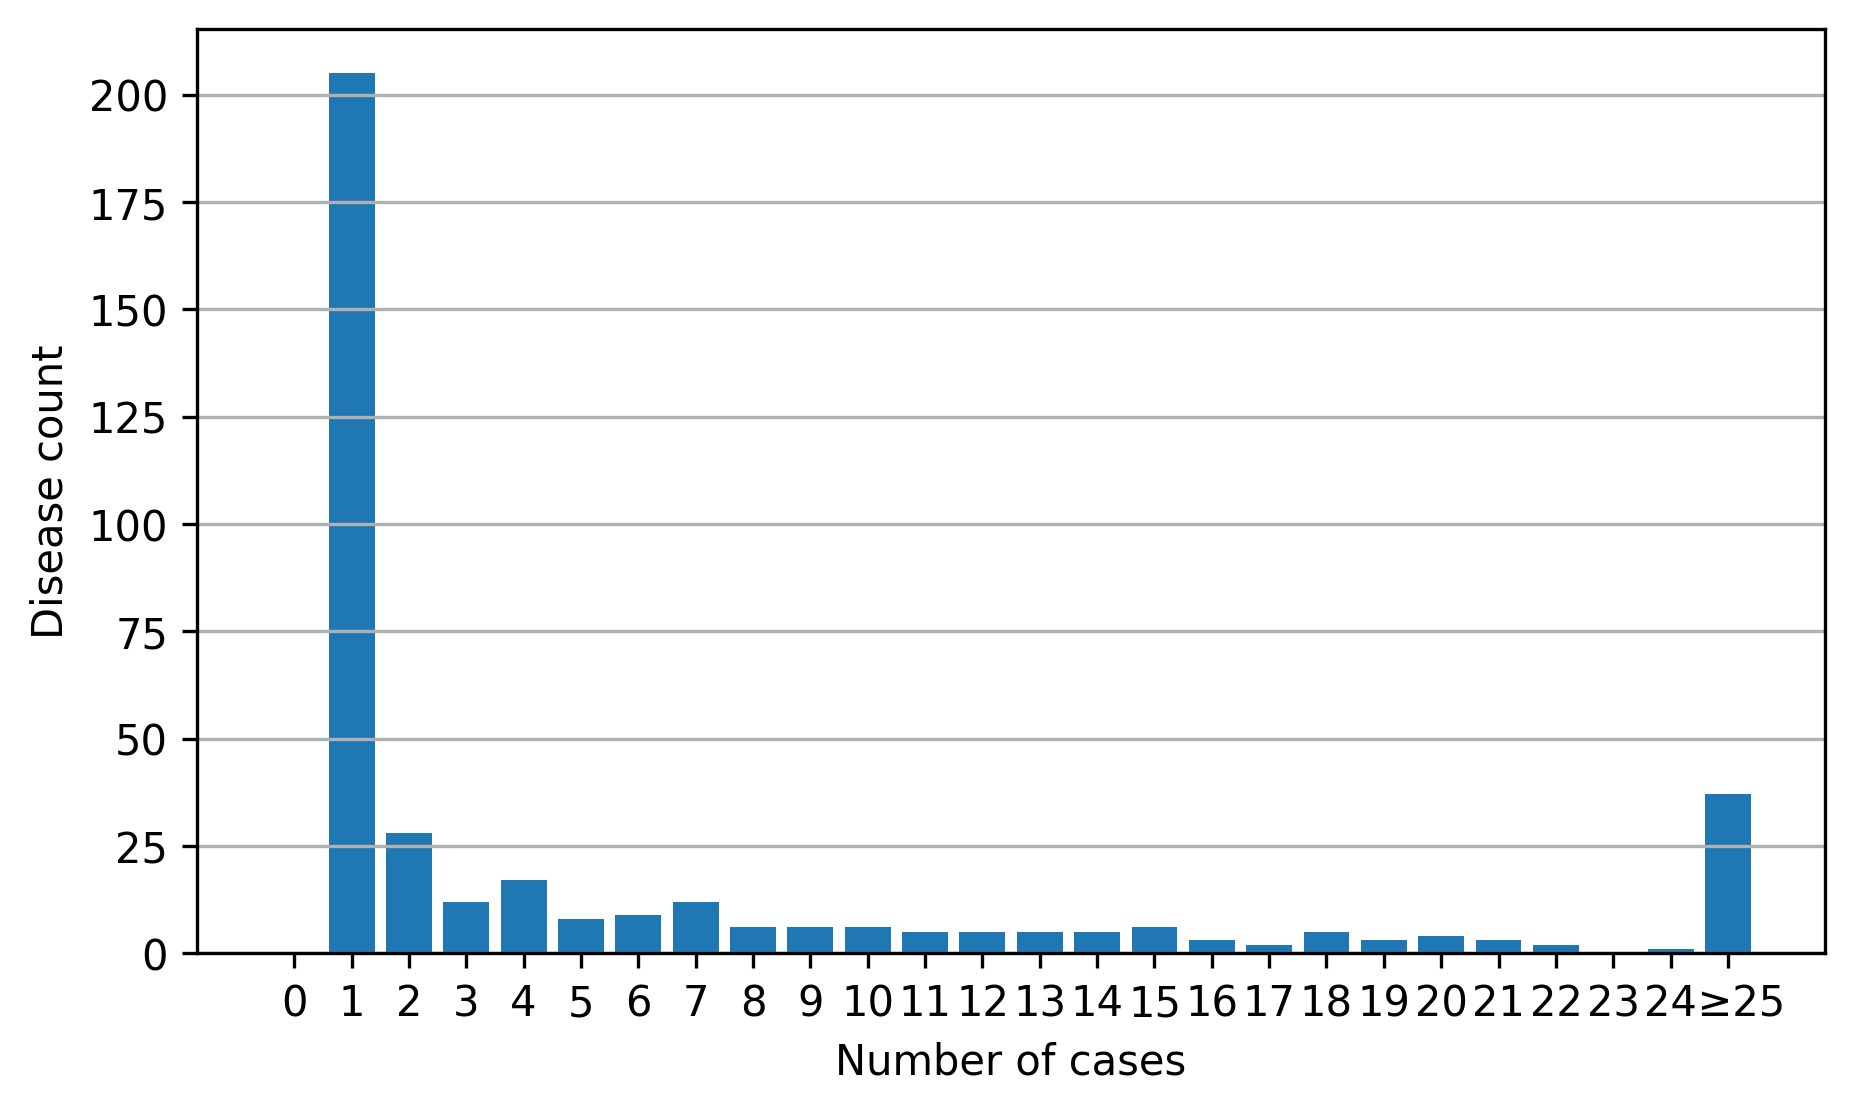

In [ ]:
plot_with_max(
    disease_counts=counts_per_disease,
    max_val=25,
)
plt.savefig('counts_per_disease.png')

# Check all disease identifiers
They should all be CURIEs with the prefixes OMIM or MONDO. There should be no whitespace between the colon and the suffix.

In [ ]:
df = stats.check_disease_id()

No problems found.


# Count diseases in cohort
In phenopacket-store, each of the folders underneath the "notebooks" folder is counted as a cohort. The following function can be used to 
display the count of diseases in a specific cohort. The intended use case is that in time we would like to move the LIRICAL phenopackets into gene-specific cohorts.

In [ ]:
input_zipfile = "all_phenopackets.zip"
target = "LIRICAL"
df = stats.count_diseases_in_cohort(input_zipfile=input_zipfile, cohort=target)
df.head(50)

,label,count
disease_id,,
OMIM:616900,"Hypotonia, infantile, with psychomotor retardation and characteristic facies 3",19
OMIM:616907,"Spastic paraplegia 76, autosomal recessive",12
OMIM:159550,Ataxia-pancytopenia syndrome,10
OMIM:617425,Immunoskeletal dysplasia with neurodevelopmental abnormalities,10
OMIM:617560,"Spastic ataxia 8, autosomal recessive, with hypomyelinating leukodystrophy",7
OMIM:616829,"Congenital disorder of glycosylation, type IIp",6
OMIM:616878,"Metabolic encephalomyopathic crises, recurrent, with rhabdomyolysis, cardiac arrhythmias, and neurodegeneration",6
OMIM:154700,MARFAN SYNDROME; MFS,4
OMIM:617516,Stankiewicz-Isidor syndrome,4


# Check for duplicates
In some cases, duplicate phenopackets were inadvertently added to some of the initial cohorts at earlier stages of the project. This function lists phenopacket identifers arranged according to variant and allows us to more easily check for this kind of error.

In [ ]:
df = stats.show_possible_duplicates_by_variant(input_zipfile, "ERI1")

No candidate duplicates found for ERI1


# Quality control
The following commands perform several consistency checks.

In [ ]:
df = stats.find_phenopackets_with_no_variants(input_zipfile=input_zipfile)

All phenopackets had at least one variant


In [ ]:
stats.show_possible_duplicates_by_variant(input_zipfile, "ARPC5")

No candidate duplicates found for ARPC5


""


In [ ]:
stats.find_phenopackets_with_no_disease(input_zipfile)

All phenopackets had a disease diagnosis


""
